<a href="https://colab.research.google.com/github/BREADLuVER/ML-notetaker/blob/main/Responsible_Datascience1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install fairlearn

In [2]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [3]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [4]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [5]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [6]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,'Over 60 years','Discharged to Home',Emergency,3,Missing,49,6,27,...,NaN,NaN,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,'Over 60 years',Other,Referral,5,Missing,57,0,21,...,NaN,NaN,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,'30-60 years','Discharged to Home',Other,4,Other,37,2,9,...,NaN,NaN,No,No,No,False,False,False,False,False
51185,Caucasian,Male,'30-60 years',Other,Other,9,InternalMedicine,61,6,27,...,NaN,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,'30-60 years','Discharged to Home',Referral,7,Other,23,0,13,...,NaN,NaN,No,No,Yes,True,False,True,True,False


## data inspectation

In [7]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [8]:
#@markdown
unique_feature_values = x_raw.apply(lambda col: col.unique())
unique_feature_values

race                        [Caucasian, AfricanAmerican, Unknown, Other, A...
gender                                                         [Male, Female]
age                         ['Over 60 years', '30-60 years', '30 years or ...
discharge_disposition_id                        ['Discharged to Home', Other]
admission_source_id                              [Emergency, Referral, Other]
time_in_hospital              [3, 5, 4, 9, 7, 8, 11, 2, 1, 6, 12, 13, 14, 10]
medical_specialty           [Missing, Other, InternalMedicine, Emergency/T...
num_lab_procedures          [49, 57, 37, 61, 23, 65, 47, 35, 51, 22, 46, 4...
num_procedures                                          [6, 0, 2, 1, 3, 4, 5]
num_medications             [27, 21, 9, 13, 40, 17, 34, 10, 19, 11, 6, 14,...
primary_diagnosis           [Other, Diabetes, 'Respiratory Issues', 'Muscu...
number_diagnoses                  [9, 5, 7, 4, 6, 8, 3, 2, 1, 16, 15, 13, 11]
max_glu_serum                                         [nan, Norm

In [9]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'insulin']


In [10]:
#@markdown standardize data types
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True)

In [11]:
#@markdown
%%capture
x_raw.apply(lambda col: col.unique())

In [12]:
x_raw.dtypes

race                                             category
age                                              category
admission_source_id                              category
time_in_hospital                                    int64
medical_specialty                                category
num_lab_procedures                                  int64
num_procedures                                      int64
num_medications                                     int64
primary_diagnosis                                category
number_diagnoses                                    int64
max_glu_serum                                      object
A1Cresult                                          object
insulin                                          category
gender_Male                                         int64
discharge_disposition_id_'Discharged to Home'       int64
change_Ch                                           int64
diabetesMed_Yes                                     int64
medicare_False

In [13]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'int64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'int64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Male,discharge_disposition_id_'Discharged to Home',change_Ch,diabetesMed_Yes,medicare_False,...,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,1,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True
86278,5,57,0,21,9,0,0,1,1,0,...,False,False,False,False,False,False,False,True,False,False
30000,4,37,2,9,5,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,False
51185,9,61,6,27,9,1,0,1,1,1,...,False,False,False,False,True,False,False,True,False,False
53902,7,23,0,13,7,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False


 # TODO: Split train, test data 80 train / 20 test


In [14]:
# write your code here

X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=123, stratify=y_raw)

# Problem 2, Part (a)
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [15]:
# write your code here
# initialize a model with RandomForestClassifier
n_estimators = 1

# train the model with the training data split
model = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1, random_state=123)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [16]:
from fairlearn.metrics import MetricFrame, false_negative_rate, false_positive_rate, selection_rate, demographic_parity_ratio, equalized_odds_ratio
from sklearn.metrics import accuracy_score
# write your code here
#num_lab_procedures
#num_procedures
#num_medications

# get model's prediction for the test set
y_pred = model.predict(X_test)

# use MetricFrame to get the results

performance_metric = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'fnr': false_negative_rate,
    'fpr': false_positive_rate,
    'selection_rate': selection_rate
}

sensitive_features = X_test['gender_Male']

metric_frame = MetricFrame(metrics=performance_metric,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sensitive_features)

print(metric_frame.overall)
print(metric_frame.by_group)

accuracy          0.539293
precision         0.502559
recall            0.520679
fnr               0.479321
fpr               0.444648
selection_rate    0.479862
dtype: float64
             accuracy  precision    recall       fnr       fpr  selection_rate
gender_Male                                                                   
0            0.549692   0.527972  0.555147  0.444853  0.455312        0.503078
1            0.526140   0.466667  0.473684  0.526316  0.432000        0.450501


In [17]:
fnr_diff = metric_frame.by_group['fnr'].max() - metric_frame.by_group['fnr'].min()
fpr_diff = metric_frame.by_group['fpr'].max() - metric_frame.by_group['fpr'].min()
sr_diff = metric_frame.by_group['selection_rate'].max() - metric_frame.by_group['selection_rate'].min()
dp_ratio = demographic_parity_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)
eo_ratio = equalized_odds_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

print(f"FNR_D: {fnr_diff}")
print(f"FPR_D: {fpr_diff}")
print(f"DPR: {dp_ratio}")
print(f"equalized_odds_ratio: {eo_ratio}")
print(f"sr_difference: {sr_diff}")

FNR_D: 0.08146284829721362
FPR_D: 0.02331197301854976
DPR: 0.895487993652621
equalized_odds_ratio: 0.8532589752527012
sr_difference: 0.05257771999182126


## performance table

In [18]:
# Create a table of performance on the metrics
metrics_summary = {
      **(metric_frame.overall.to_dict()),
    'fnr_diff': fnr_diff,
    'fpr_diff': fpr_diff,
    'sr_diff': sr_diff,
    'dp_ratio': dp_ratio,
    'eo_ratio': eo_ratio
}

metrics_table = pd.DataFrame(list(metrics_summary.items()), columns=['Metric', 'Value'])
performance_metric = pd.DataFrame(list(metrics_summary.items())[0:6], columns=['Metric', 'Value'])
difference_metrics_table = pd.DataFrame(list(metrics_summary.items())[6:9], columns=['Metric', 'Value'])
ratio_metrics_table = pd.DataFrame(list(metrics_summary.items())[9:], columns=['Metric', 'Value'])
print(metrics_table)
#print(difference_metrics_table)
#print(ratio_metrics_table)

            Metric     Value
0         accuracy  0.539293
1        precision  0.502559
2           recall  0.520679
3              fnr  0.479321
4              fpr  0.444648
5   selection_rate  0.479862
6         fnr_diff  0.081463
7         fpr_diff  0.023312
8          sr_diff  0.052578
9         dp_ratio  0.895488
10        eo_ratio  0.853259


Print Results

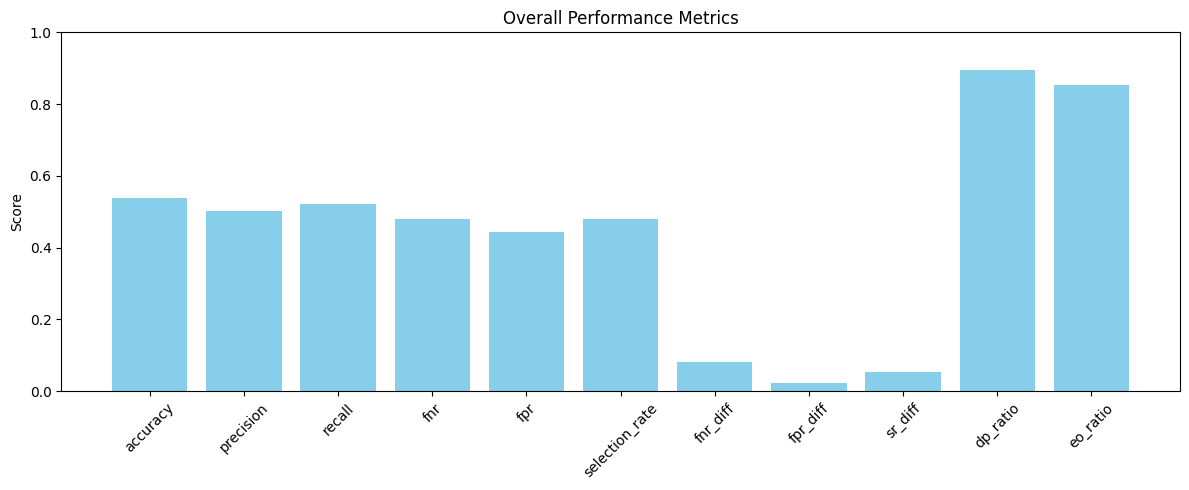

In [19]:
#@markdown
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(12, 5))

ax.bar(metrics_table['Metric'], metrics_table['Value'], color='skyblue')
ax.set_title('Overall Performance Metrics')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Overall Performance metrics
Looking at the first graph, for overall performance meterics like accuracy, precision, recall, FNR, FPR, we have the following scores, which is not very good.

accuracy  0.539293

precision  0.502559

recall  0.520679

fnr  0.479321

fpr  0.444648

These scores suggests that the model has a 53% chance to accuratly predict diabetes readmission, when the model predicts a readmission, it is accurate about 50.2%, model identifies 52% of all actual readmissions, nearly 47% of the true readmissions are missed by the model, and 44% of non-readmissions are incorrectly marked as readmissions. Again the model does not look ready



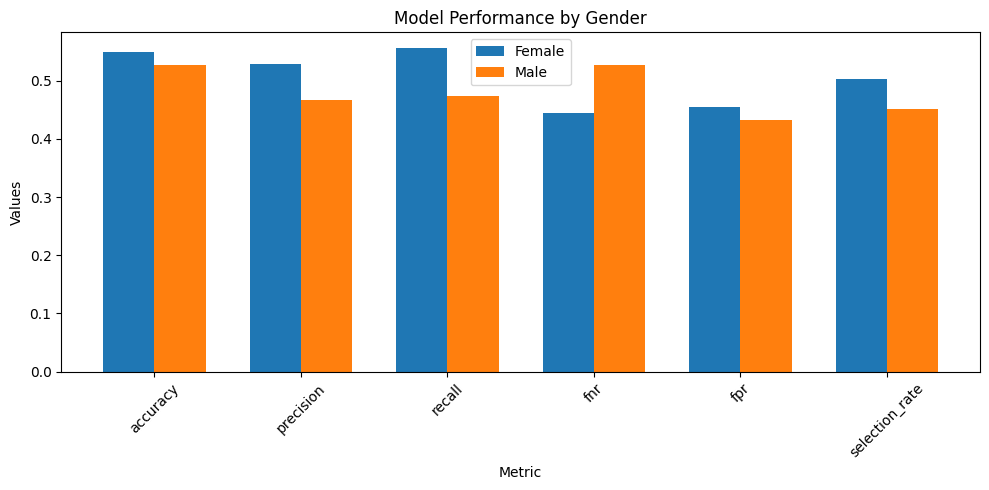

In [20]:
#@markdown
m_bygroup_dict = metric_frame.by_group.to_dict()
#print(m_bygroup_dict)

groups = ['Female', 'Male']
metrics = list(m_bygroup_dict.keys())
n_metrics = len(metrics)

fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.35
indices = np.arange(n_metrics)

for i, group in enumerate(groups):
    positions = [x + bar_width * i for x in indices]
    group_metrics = [m_bygroup_dict[metric][i] for metric in metrics]
    ax.bar(positions, group_metrics, width=bar_width, label=group)

ax.set_xlabel('Metric')
ax.set_ylabel('Values')
ax.set_title('Model Performance by Gender')
ax.set_xticks([r + bar_width/2 for r in range(n_metrics)])
ax.set_xticklabels(metrics)
ax.legend()

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Report


## Gender comparison
From the second graph above, we can clearly see that females (0) generally have a better score compared to their male counterpart on the expect the metric fnr. This suggests that the model is better at predicting female diabetes readmission (accuracy), has a higher chance to be correct when they predict readmission (precision), a lot less female patients who were readmitted got missed by the model (recall). Moreover, the model tends to predict a higher proportion of female to be at risk of readmission (selection rate), and incorrectly predicts readmission more frequently (FPR).

The most important find from graph two is probably the higher FPR and lower FNR compared to males for females, this inbalance means that the model is more likely to incorrectly flag females as at risk of readmission (higher FPR), but better at catching actual cases of readmission among females (lower FNR).We will want to balance these scores if possible.

For the males most metrics are lower compared to females, the model does not perform better for them. However, they have a lower FPR and higher FNR, suggesting there's less false alarms but more males are missed when marking for readmission.




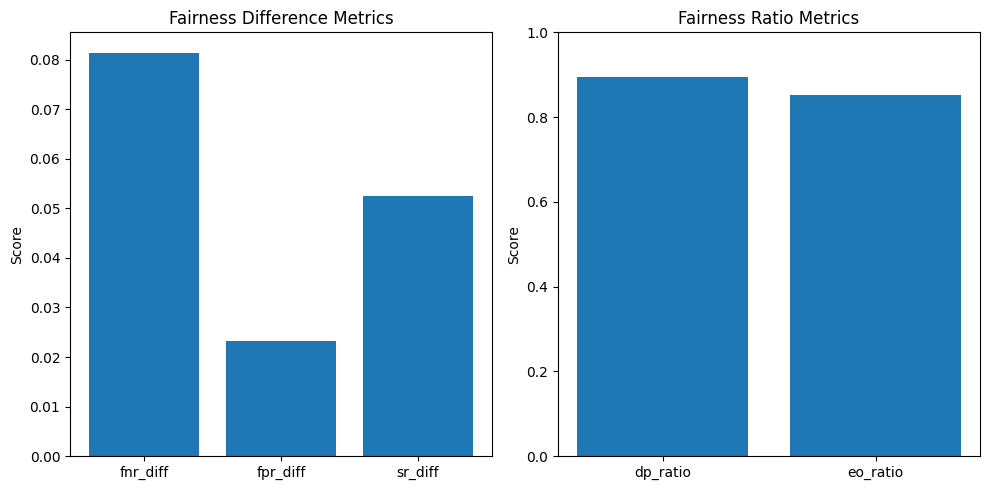

In [21]:
#@markdown

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].bar(difference_metrics_table['Metric'], difference_metrics_table['Value'])
ax[0].set_title('Fairness Difference Metrics')
ax[0].set_ylabel('Score')

ax[1].bar(ratio_metrics_table['Metric'], ratio_metrics_table['Value'])
ax[1].set_title('Fairness Ratio Metrics')
ax[1].set_ylabel('Score')
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

Fairness metrics as shown above suggests that the model is not extremly biased but is imperfect nontheless.

FNR Difference (0.081463): 8.15% more likley for one gender to receive false alarms than another compared to another.

FPR Difference (0.023312): A 2.33% higher probability of false alarms for one gender over another.

Selection Rate Difference (0.052578): A 5.26% difference in how frequently gender are flagged for readmission.

Demographic Parity Ratio (0.895488): A gender is selected at a rate 89.5% that of the most favored gender. This is close to 90%, which I believe is considered "fair"?

Equalized Odds Ratio (0.853259): 15% less accurate for one gender, more inaccurate for one gender.

# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [22]:
# write your code here
n_estimators = 1000
max_depth = 10

X_train2, X_test2, y_train2, y_test2 = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=123, stratify=y_raw)

model2 = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=123)
model2.fit(X_train2, y_train2)


RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=123)

Calculate metrics with Fairlearn MetricFrame
and print the results

In [23]:
y_pred_baseline2 = model2.predict(X_test2)

performance_metric2 = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'fnr': false_negative_rate,
    'fpr': false_positive_rate,
    'selection_rate': selection_rate
}

sensitive_features2 = X_test2['gender_Male']

metric_frame2 = MetricFrame(metrics=performance_metric2,
                           y_true=y_test2,
                           y_pred=y_pred_baseline2,
                           sensitive_features=sensitive_features2)

print(metric_frame2.overall)
print(metric_frame2.by_group)

accuracy          0.614931
precision         0.605859
recall            0.482503
fnr               0.517497
fpr               0.270814
selection_rate    0.368861
dtype: float64
             accuracy  precision    recall       fnr       fpr  selection_rate
gender_Male                                                                   
0            0.613896   0.614379  0.518382  0.481618  0.298482        0.403694
1            0.616240   0.592466  0.433584  0.566416  0.238000        0.324805


In [24]:
fnr_diff2 = metric_frame2.by_group['fnr'].max() - metric_frame2.by_group['fnr'].min()
fpr_diff2 = metric_frame2.by_group['fpr'].max() - metric_frame2.by_group['fpr'].min()
sr_diff2 = metric_frame2.by_group['selection_rate'].max() - metric_frame2.by_group['selection_rate'].min()
dp_ratio2 = demographic_parity_ratio(y_true=y_test2, y_pred=y_pred_baseline2, sensitive_features=sensitive_features2)
eo_ratio2 = equalized_odds_ratio(y_true=y_test2, y_pred=y_pred_baseline2, sensitive_features=sensitive_features2)

print(f"FNR_D: {fnr_diff2}")
print(f"FPR_D: {fpr_diff2}")
print(f"DPR: {dp_ratio2}")
print(f"equalized_odds_ratio: {eo_ratio2}")
print(f"sr_difference: {sr_diff2}")

FNR_D: 0.08479839304142706
FPR_D: 0.060482293423271494
DPR: 0.8045831606650817
equalized_odds_ratio: 0.797367231638418
sr_difference: 0.07888859213256594


In [25]:
#@markdown
metrics_summary2 = {
      **(metric_frame2.overall.to_dict()),
    'fnr_diff': fnr_diff2,
    'fpr_diff': fpr_diff2,
    'sr_diff': sr_diff2,
    'dp_ratio': dp_ratio2,
    'eo_ratio': eo_ratio2
}

metrics_table2 = pd.DataFrame(list(metrics_summary2.items()), columns=['Metric', 'Value'])
performance_metric2 = pd.DataFrame(list(metrics_summary2.items())[0:6], columns=['Metric', 'Value'])
difference_metrics_table2 = pd.DataFrame(list(metrics_summary2.items())[6:9], columns=['Metric', 'Value'])
ratio_metrics_table2 = pd.DataFrame(list(metrics_summary2.items())[9:], columns=['Metric', 'Value'])

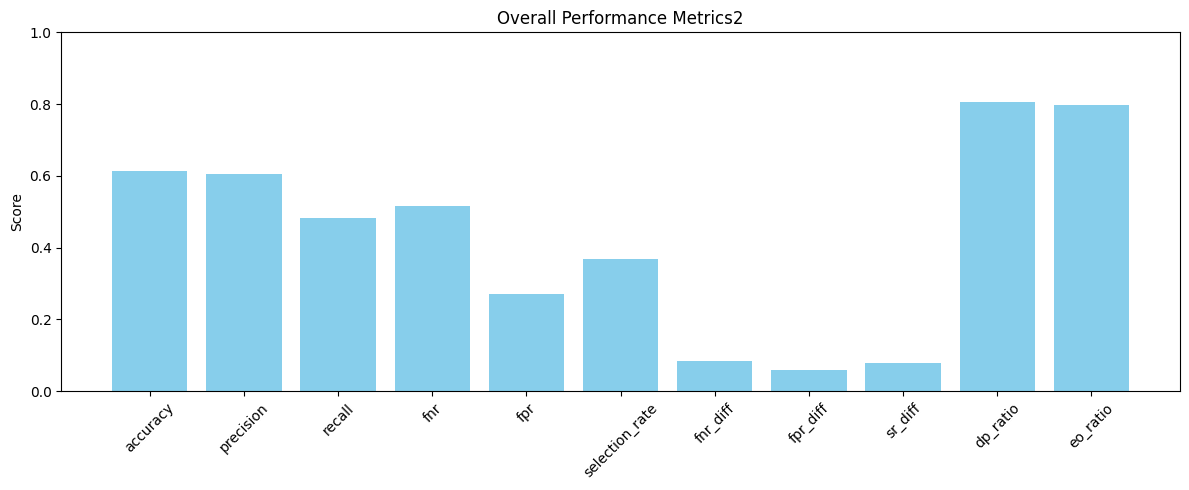

In [26]:
#@markdown
fig, ax = plt.subplots(1, figsize=(12, 5))

ax.bar(metrics_table2['Metric'], metrics_table2['Value'], color='skyblue')
ax.set_title('Overall Performance Metrics2')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

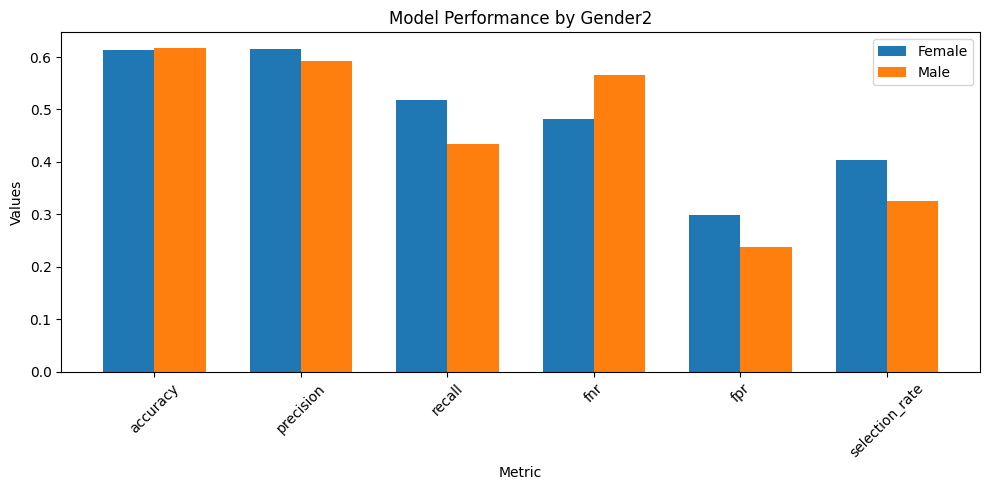

In [27]:
#@markdown
m_bygroup_dict = metric_frame2.by_group.to_dict()
#print(m_bygroup_dict)

groups = ['Female', 'Male']
metrics = list(m_bygroup_dict.keys())
n_metrics = len(metrics)

fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.35
indices = np.arange(n_metrics)

for i, group in enumerate(groups):
    positions = [x + bar_width * i for x in indices]
    group_metrics = [m_bygroup_dict[metric][i] for metric in metrics]
    ax.bar(positions, group_metrics, width=bar_width, label=group)

ax.set_xlabel('Metric')
ax.set_ylabel('Values')
ax.set_title('Model Performance by Gender2')
ax.set_xticks([r + bar_width/2 for r in range(n_metrics)])
ax.set_xticklabels(metrics)
ax.legend()

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

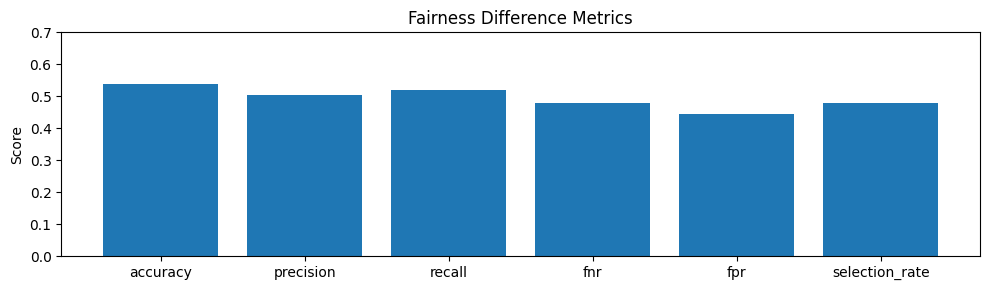

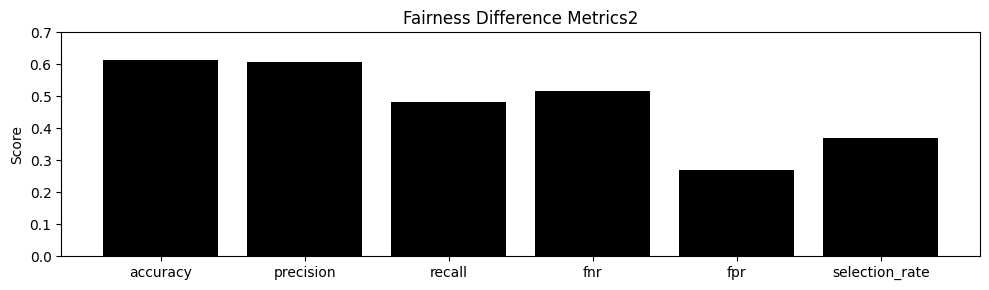

In [28]:
#@markdown
#performance_metric
fig, ax = plt.subplots(1, figsize=(10, 3))

ax.bar(performance_metric['Metric'], performance_metric['Value'])
ax.set_title('Fairness Difference Metrics')
ax.set_ylabel('Score')
ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(10, 3))

ax.bar(performance_metric2['Metric'], performance_metric2['Value'],  color='black')
ax.set_title('Fairness Difference Metrics2')
ax.set_ylabel('Score')
ax.set_ylim(0, 0.7)
plt.tight_layout()
plt.show()

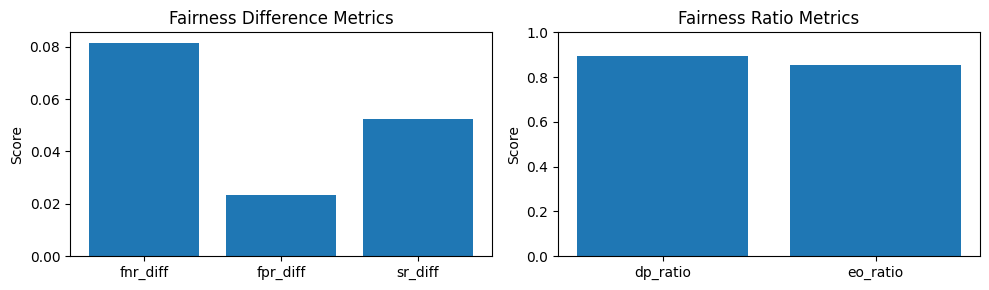

(0.0, 1.0)

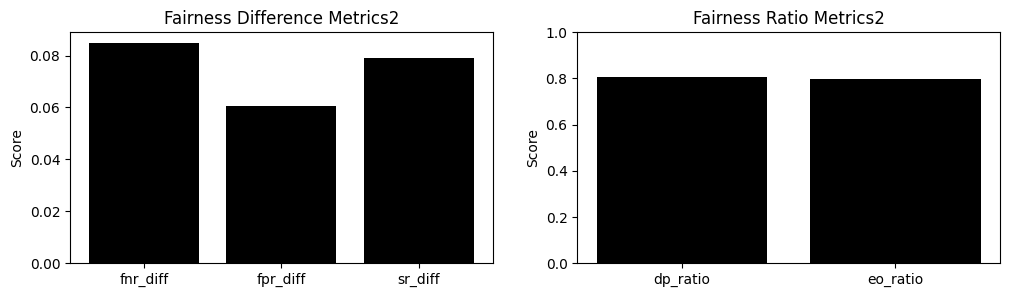

In [29]:
#@markdown

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].bar(difference_metrics_table['Metric'], difference_metrics_table['Value'])
ax[0].set_title('Fairness Difference Metrics')
ax[0].set_ylabel('Score')

ax[1].bar(ratio_metrics_table['Metric'], ratio_metrics_table['Value'])
ax[1].set_title('Fairness Ratio Metrics')
ax[1].set_ylabel('Score')
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].bar(difference_metrics_table2['Metric'], difference_metrics_table2['Value'],  color='black')
ax[0].set_title('Fairness Difference Metrics2')
ax[0].set_ylabel('Score')

ax[1].bar(ratio_metrics_table2['Metric'], ratio_metrics_table2['Value'],  color='black')
ax[1].set_title('Fairness Ratio Metrics2')
ax[1].set_ylabel('Score')
ax[1].set_ylim(0, 1)

From the visualizations above, we can clearly see that model2 seems to sacrifice "fairness" for "performance."

To start, both accuracy and precision increased by about 10% for model2, this means that it is better at identifying both readmittion/non-readmission patients and more reliable on predicting readmittion (higher ratio of true positive).
The increase in precision and accuracy results in decrease in recall (-4%) and increase in fnr (+3%), suggesting that a greater proportion of patients who will be readmitted will likely be missed by the model now.
FPR on the otherhand decreased by 17%, which is very good as less false readmission will be predicted.
Regarding the fairness metrics, there is a general increase in FNR FPR SR difference, alongside a general decrease in demographic and equalized odds ratios. These trends all points to the fact that the model may be more biased, potentially exacerbating disparities between gender groups.

What we did in model2 is increasing trees to 1000 and depth limit to 10. By increasing the number of trees allows the model to average over more trees, which might reduce variance. However, more averaging/generalization might amplify underlying bias which explains the reduce in fairness
Similarly, by setting max_depth to 10 we essentially tells the model to not overfit to much, which leads to better generalization to unseen data but at the same time loses some capacity in capturing complex patterns for implementing gender fairness.

# Problem 2, Part (c)
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [38]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True

performance_metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'fnr': false_negative_rate,
    'fpr': false_positive_rate,
    'selection_rate': selection_rate
}

def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    metric_frame = MetricFrame(metrics={
        'fnr': false_negative_rate,
        'fpr': false_positive_rate,
        'selection_rate': selection_rate
    },
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_features)

    fnr_diff = metric_frame.by_group['fnr'].max() - metric_frame.by_group['fnr'].min()
    fpr_diff = metric_frame.by_group['fpr'].max() - metric_frame.by_group['fpr'].min()
    sr_diff = metric_frame.by_group['selection_rate'].max() - metric_frame.by_group['selection_rate'].min()

    fnr = metric_frame.overall['fnr']
    fpr = metric_frame.overall['fpr']
    sr = metric_frame.overall['selection_rate']

    dp_ratio = demographic_parity_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    eo_ratio = equalized_odds_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)

    return fnr, fpr, sr, fnr_diff, fpr_diff, sr_diff, dp_ratio, eo_ratio


metrics_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fnr': [],
    'fpr': [],
    'selection_rate': [],
    'fnr_diff': [],
    'fpr_diff': [],
    'sr_diff': [],
    'dp_ratio': [],
    'eo_ratio': []
}

alpha_values = [0.0, 0.3, 0.7, 1.0]
seeds = range(10)

for seed in seeds:
    for alpha in alpha_values:
        afc = AdversarialFairnessClassifier(
            backend='tensorflow',
            predictor_model=[128, 64, 32, 16, 8],
            adversary_model=[32, 16, 8],
            learning_rate=0.001,
            epochs=3,
            batch_size=16,
            constraints='demographic_parity',
            random_state=seed,
            shuffle=True,
            alpha=alpha
        )
        afc.fit(X_train2, y_train2, sensitive_features=X_train2['gender_Male'])
        y_pred_afc = afc.predict(X_test2)

        accuracy = accuracy_score(y_test2, y_pred_afc)
        precision = precision_score(y_test2, y_pred_afc)
        recall = recall_score(y_test2, y_pred_afc)

        fnr, fpr, sr, fnr_diff, fpr_diff, sr_diff, dp_ratio, eo_ratio = calculate_fairness_metrics(
            y_true=y_test2,
            y_pred=y_pred_afc,
            sensitive_features=X_test2['gender_Male']
        )

        print(accuracy)
        metrics_results['accuracy'].append(accuracy)
        metrics_results['precision'].append(precision)
        metrics_results['recall'].append(recall)
        metrics_results['fnr'].append(fnr)
        metrics_results['fpr'].append(fpr)
        metrics_results['selection_rate'].append(sr)
        metrics_results['fnr_diff'].append(fnr_diff)
        metrics_results['fpr_diff'].append(fpr_diff)
        metrics_results['sr_diff'].append(sr_diff)
        metrics_results['dp_ratio'].append(dp_ratio)
        metrics_results['eo_ratio'].append(eo_ratio)

print(metrics_results)
backup3= metrics_results.copy()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5957760314341847


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5884086444007859


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5844793713163065


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5756385068762279


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5638506876227898


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5785854616895875


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.574656188605108


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5785854616895875


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5992141453831041


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5672888015717092


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5952848722986247


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.6075638506876228


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5466601178781926


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5402750491159135


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5343811394891945


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5211198428290766


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5888998035363457


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5928290766208252


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5834970530451866


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5667976424361493


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5510805500982319


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5736738703339882


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.581532416502947


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5884086444007859


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.556483300589391


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5741650294695482


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5510805500982319


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5638506876227898


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5776031434184676


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5486247544204322


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5594302554027505


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5766208251473477


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5707269155206287


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5658153241650294


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5756385068762279


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5884086444007859


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.49361493123772104


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.49803536345776034


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.5108055009823183


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


0.4960707269155206
{'accuracy': [0.5957760314341847, 0.5884086444007859, 0.5844793713163065, 0.5756385068762279, 0.5638506876227898, 0.5785854616895875, 0.574656188605108, 0.5785854616895875, 0.5992141453831041, 0.5672888015717092, 0.5952848722986247, 0.6075638506876228, 0.5466601178781926, 0.5402750491159135, 0.5343811394891945, 0.5211198428290766, 0.5888998035363457, 0.5928290766208252, 0.5834970530451866, 0.5667976424361493, 0.5510805500982319, 0.5736738703339882, 0.581532416502947, 0.5884086444007859, 0.556483300589391, 0.5741650294695482, 0.5510805500982319, 0.5638506876227898, 0.5776031434184676, 0.5486247544204322, 0.5594302554027505, 0.5766208251473477, 0.5707269155206287, 0.5658153241650294, 0.5756385068762279, 0.5884086444007859, 0.49361493123772104, 0.49803536345776034, 0.5108055009823183, 0.4960707269155206], 'precision': [0.56, 0.6462395543175488, 0.569583931133429, 0.5549374130737135, 0.5964912280701754, 0.6049382716049383, 0.5865168539325842, 0.5934065934065934, 0.661577

In [39]:
print(metrics_results)

{'accuracy': [0.5957760314341847, 0.5884086444007859, 0.5844793713163065, 0.5756385068762279, 0.5638506876227898, 0.5785854616895875, 0.574656188605108, 0.5785854616895875, 0.5992141453831041, 0.5672888015717092, 0.5952848722986247, 0.6075638506876228, 0.5466601178781926, 0.5402750491159135, 0.5343811394891945, 0.5211198428290766, 0.5888998035363457, 0.5928290766208252, 0.5834970530451866, 0.5667976424361493, 0.5510805500982319, 0.5736738703339882, 0.581532416502947, 0.5884086444007859, 0.556483300589391, 0.5741650294695482, 0.5510805500982319, 0.5638506876227898, 0.5776031434184676, 0.5486247544204322, 0.5594302554027505, 0.5766208251473477, 0.5707269155206287, 0.5658153241650294, 0.5756385068762279, 0.5884086444007859, 0.49361493123772104, 0.49803536345776034, 0.5108055009823183, 0.4960707269155206], 'precision': [0.56, 0.6462395543175488, 0.569583931133429, 0.5549374130737135, 0.5964912280701754, 0.6049382716049383, 0.5865168539325842, 0.5934065934065934, 0.6615776081424937, 0.61567

In [40]:
backup= metrics_results.copy()

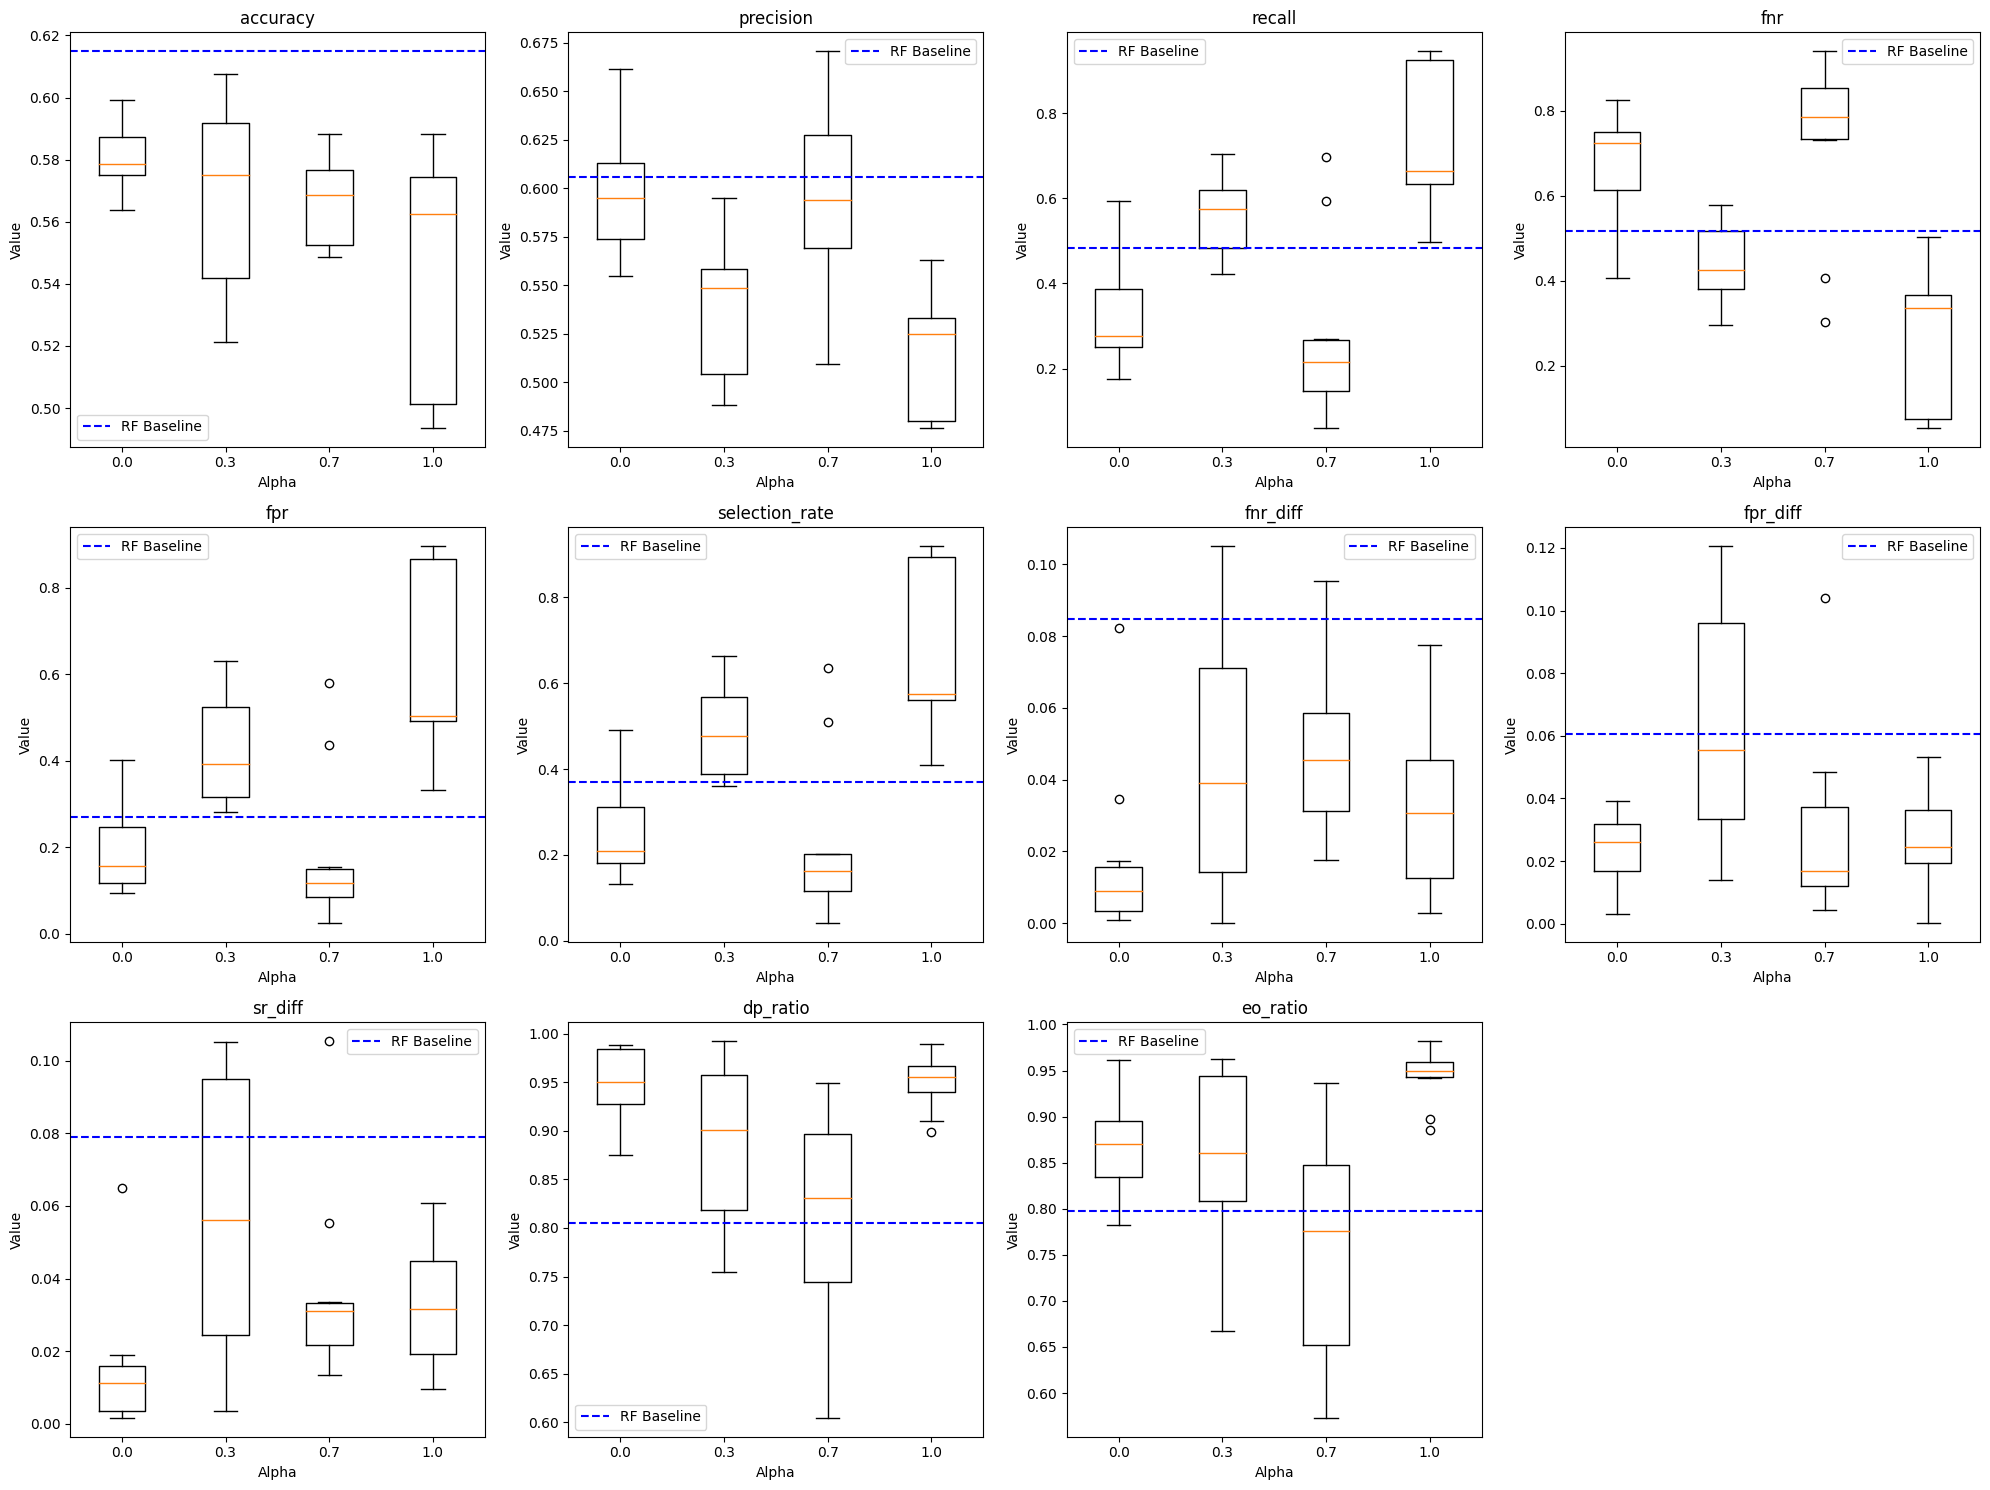

In [54]:
#@markdown ### Plot all our metrics as line plots while varying alpha

metrics_results=backup.copy()

data_m = {metric: [metrics_results[metric][i:i+10] for i in range(0, len(metrics_results[metric]), 10)] for metric in metrics_results}
comparison = metrics_table2.set_index('Metric')['Value'].to_dict()
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()

for idx, (metric, data) in enumerate(data_m.items()):
    if np.var(data) <= 0:
        axs[idx].annotate(f'Constant value: {data[0][0]}',
                          xy=(0.5, 0.5),
                          xycoords='axes fraction',
                          ha='center')
    else:
        axs[idx].boxplot(data, labels=['0.0', '0.3', '0.7', '1.0'])
        axs[idx].set_xlabel('Alpha')
        axs[idx].set_ylabel('Value')

    axs[idx].set_title(metric)

    cvalue = comparison.get(metric, None)
    if cvalue is not None:
        axs[idx].axhline(y=cvalue, color='b', linestyle='--', label='RF Baseline')
        axs[idx].legend()

for idx in range(len(data_m), len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

There's no hardly any noticable pattern from the data output when we tweak with the alpha value. However, it does seem like alpha 0.3 has the best and most consistent results for our model and dataset.



# Problem 2, Part (d)
### **Threshold Optimizer Post-processing intervention**



In [42]:
#@markdown Fit the ThresholdOptimizer model here

def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    metric_frame = MetricFrame(metrics={
        'fnr': false_negative_rate,
        'fpr': false_positive_rate,
        'selection_rate': selection_rate
    },
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_features)

    fnr_diff = metric_frame.by_group['fnr'].max() - metric_frame.by_group['fnr'].min()
    fpr_diff = metric_frame.by_group['fpr'].max() - metric_frame.by_group['fpr'].min()
    sr_diff = metric_frame.by_group['selection_rate'].max() - metric_frame.by_group['selection_rate'].min()

    dp_ratio = demographic_parity_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    eo_ratio = equalized_odds_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)

    return fnr_diff, fpr_diff, sr_diff, dp_ratio, eo_ratio

performance_metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'fnr': false_negative_rate,
    'fpr': false_positive_rate,
    'selection_rate': selection_rate
}

results = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        x_numeric, y_raw, test_size=0.2, random_state=i, stratify=y_raw)

    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=i)
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)

    postprocess_est = ThresholdOptimizer(
        estimator=rf_clf,
        constraints='equalized_odds',
        objective='balanced_accuracy_score',
        prefit=True,
        predict_method='predict_proba'
    )

    postprocess_est.fit(X_train, y_train, sensitive_features=X_train['gender_Male'])
    y_pred_post = postprocess_est.predict(X_test, sensitive_features=X_test['gender_Male'])

    rf_metrics = {metric_name: metric_func(y_test, y_pred_rf) for metric_name, metric_func in performance_metrics.items()}
    post_metrics = {metric_name: metric_func(y_test, y_pred_post) for metric_name, metric_func in performance_metrics.items()}

    rf_fairness_metrics = calculate_fairness_metrics(y_test, y_pred_rf, X_test['gender_Male'])
    post_fairness_metrics = calculate_fairness_metrics(y_test, y_pred_post, X_test['gender_Male'])

    results.append({
        'split': i,
        'random_forest': {**rf_metrics, 'fnr_diff': rf_fairness_metrics[0], 'fpr_diff': rf_fairness_metrics[1], 'sr_diff': rf_fairness_metrics[2], 'dp_ratio': rf_fairness_metrics[3], 'eo_ratio': rf_fairness_metrics[4]},
        'threshold_optimizer': {**post_metrics, 'fnr_diff': post_fairness_metrics[0], 'fpr_diff': post_fairness_metrics[1], 'sr_diff': post_fairness_metrics[2], 'dp_ratio': post_fairness_metrics[3], 'eo_ratio': post_fairness_metrics[4]}
    })

results_df = pd.DataFrame(results)

In [51]:
#@markdown normalizing
print(results_df['threshold_optimizer'])
threshold_temp = pd.DataFrame(results_df['threshold_optimizer'])
threshold_optimizer = pd.melt(threshold_temp, var_name='Metric', value_name='Value')

print(threshold_optimizer)

0    {'accuracy': 0.6055992141453831, 'precision': ...
1    {'accuracy': 0.5928290766208252, 'precision': ...
2    {'accuracy': 0.5943025540275049, 'precision': ...
3    {'accuracy': 0.6198428290766208, 'precision': ...
4    {'accuracy': 0.5947937131630648, 'precision': ...
5    {'accuracy': 0.6114931237721022, 'precision': ...
6    {'accuracy': 0.5884086444007859, 'precision': ...
7    {'accuracy': 0.6178781925343811, 'precision': ...
8    {'accuracy': 0.5977406679764243, 'precision': ...
9    {'accuracy': 0.6114931237721022, 'precision': ...
Name: threshold_optimizer, dtype: object
                Metric                                              Value
0  threshold_optimizer  {'accuracy': 0.6055992141453831, 'precision': ...
1  threshold_optimizer  {'accuracy': 0.5928290766208252, 'precision': ...
2  threshold_optimizer  {'accuracy': 0.5943025540275049, 'precision': ...
3  threshold_optimizer  {'accuracy': 0.6198428290766208, 'precision': ...
4  threshold_optimizer  {'accuracy': 0.

In [50]:
backup2={'accuracy': [0.5957760314341847, 0.5884086444007859, 0.5844793713163065, 0.5756385068762279, 0.5638506876227898, 0.5785854616895875, 0.574656188605108, 0.5785854616895875, 0.5992141453831041, 0.5672888015717092, 0.5952848722986247, 0.6075638506876228, 0.5466601178781926, 0.5402750491159135, 0.5343811394891945, 0.5211198428290766, 0.5888998035363457, 0.5928290766208252, 0.5834970530451866, 0.5667976424361493, 0.5510805500982319, 0.5736738703339882, 0.581532416502947, 0.5884086444007859, 0.556483300589391, 0.5741650294695482, 0.5510805500982319, 0.5638506876227898, 0.5776031434184676, 0.5486247544204322, 0.5594302554027505, 0.5766208251473477, 0.5707269155206287, 0.5658153241650294, 0.5756385068762279, 0.5884086444007859, 0.49361493123772104, 0.49803536345776034, 0.5108055009823183, 0.4960707269155206], 'precision': [0.56, 0.6462395543175488, 0.569583931133429, 0.5549374130737135, 0.5964912280701754, 0.6049382716049383, 0.5865168539325842, 0.5934065934065934, 0.6615776081424937, 0.6156716417910447, 0.5582761998041136, 0.5949868073878628, 0.508695652173913, 0.5030146425495263, 0.49812171299774605, 0.48814814814814816, 0.5576086956521739, 0.574025974025974, 0.5558166862514688, 0.5416098226466576, 0.5617021276595745, 0.654320987654321, 0.6194225721784777, 0.630272952853598, 0.5909090909090909, 0.5917874396135265, 0.6705882352941176, 0.5964912280701754, 0.5400192864030858, 0.5092879256965944, 0.5201048951048951, 0.5348237317282889, 0.5301310043668123, 0.5328142380422692, 0.5334462320067739, 0.562874251497006, 0.47649572649572647, 0.47872913301023157, 0.48493462194428655, 0.47745790331341664], 'recall': [0.5938494167550371, 0.24602332979851538, 0.4209968186638388, 0.42311770943796395, 0.18027571580063625, 0.2598091198303287, 0.2767762460233298, 0.2863202545068929, 0.2757158006362672, 0.17497348886532343, 0.6044538706256628, 0.4782608695652174, 0.6203605514316013, 0.6193001060445387, 0.7030752916224814, 0.6988335100742312, 0.5440084835630965, 0.4687168610816543, 0.5015906680805938, 0.4209968186638388, 0.13997879109225875, 0.16861081654294804, 0.25026511134676566, 0.26935312831389185, 0.1378579003181336, 0.2598091198303287, 0.060445387062566275, 0.18027571580063625, 0.5938494167550371, 0.6977730646871686, 0.630965005302227, 0.6595970307529162, 0.6436903499469777, 0.5079533404029692, 0.6680805938494168, 0.4984093319194062, 0.9459172852598091, 0.9427359490986215, 0.9045599151643691, 0.9321314952279958], 'fnr': [0.4061505832449629, 0.7539766702014846, 0.5790031813361611, 0.5768822905620361, 0.8197242841993637, 0.7401908801696713, 0.7232237539766702, 0.7136797454931071, 0.7242841993637328, 0.8250265111346765, 0.3955461293743372, 0.5217391304347826, 0.3796394485683987, 0.3806998939554613, 0.29692470837751855, 0.30116648992576883, 0.4559915164369035, 0.5312831389183457, 0.4984093319194062, 0.5790031813361611, 0.8600212089077413, 0.8313891834570519, 0.7497348886532343, 0.7306468716861082, 0.8621420996818664, 0.7401908801696713, 0.9395546129374337, 0.8197242841993637, 0.4061505832449629, 0.3022269353128314, 0.36903499469777307, 0.3404029692470838, 0.3563096500530223, 0.49204665959703076, 0.33191940615058324, 0.5015906680805938, 0.05408271474019088, 0.05726405090137858, 0.09544008483563096, 0.06786850477200425], 'fpr': [0.4025617566331198, 0.1161939615736505, 0.2744739249771272, 0.292772186642269, 0.10521500457456541, 0.1463860933211345, 0.16834400731930466, 0.16925892040256177, 0.12168344007319305, 0.09423604757548033, 0.4126258005489479, 0.2808783165599268, 0.5169258920402562, 0.5279048490393413, 0.6111619396157365, 0.6322049405306496, 0.37236962488563585, 0.3000914913083257, 0.3458371454711802, 0.3074107959743824, 0.09423604757548033, 0.0768526989935956, 0.13266239707227814, 0.13632204940530648, 0.08234217749313816, 0.1546203110704483, 0.025617566331198535, 0.10521500457456541, 0.4364135407136322, 0.5800548947849954, 0.5022872827081427, 0.494967978042086, 0.4922232387923147, 0.38426349496797807, 0.5041171088746569, 0.33394327538883806, 0.8966148215919487, 0.8856358645928637, 0.8289112534309241, 0.8801463860933212], 'selection_rate': [0.4911591355599214, 0.1763261296660118, 0.3423379174852652, 0.3531434184675835, 0.13998035363457761, 0.19891944990176819, 0.21856581532416502, 0.22347740667976423, 0.19302554027504912, 0.13163064833005894, 0.5014734774066798, 0.37229862475442044, 0.5648330058939096, 0.5702357563850687, 0.6537328094302554, 0.6630648330058939, 0.4518664047151277, 0.3781925343811395, 0.4179764243614931, 0.3600196463654224, 0.11542239685658154, 0.1193516699410609, 0.18713163064833005, 0.19793713163064833, 0.10805500982318271, 0.20333988212180745, 0.04174852652259332, 0.13998035363457761, 0.5093320235756386, 0.6345776031434185, 0.5618860510805501, 0.5712180746561886, 0.56237721021611, 0.44155206286836934, 0.5800589390962672, 0.41011787819253437, 0.9194499017681729, 0.9120825147347741, 0.8639489194499018, 0.9042239685658153], 'fnr_diff': [0.08231055580126784, 0.009398496240601517, 0.03465925844021822, 0.0007647795960489256, 0.008384932920536659, 0.01014945451864957, 0.001884306354120624, 0.00763858174848886, 0.017331932773109182, 0.0008062435500515441, 0.1050374097007224, 0.07310095090667851, 0.09351043048798463, 0.0569161875276426, 0.019667735515258744, 0.012314794338788126, 0.004086503022261545, 7.832080200498304e-05, 0.021137402329352795, 0.06507076514816446, 0.060178018575851366, 0.044642857142857095, 0.06454094795813059, 0.054184173669467706, 0.030388471177944854, 0.028951054105852858, 0.0342446189001917, 0.01768207282913159, 0.09534405867610202, 0.04600195341294416, 0.033691766180156235, 0.05725711337166445, 0.07747309450095824, 0.0029255123101872282, 0.011139982308712937, 0.003759398496240629, 0.02789602683178534, 0.03975932478254459, 0.04743937048503612, 0.017032470883090074], 'fpr_diff': [0.037898819561551444, 0.021760539629005066, 0.028617200674536214, 0.0391264755480607, 0.008819561551433389, 0.0029747048903878415, 0.03254300168634064, 0.02348397976391231, 0.030074198988195633, 0.015180438448566619, 0.08593929173693088, 0.06797301854974708, 0.10861045531197305, 0.09935581787521086, 0.042691399662731944, 0.03355480607082628, 0.014064080944350743, 0.03334569983136598, 0.018731871838111258, 0.12056323777403039, 0.048357504215851596, 0.012630691399662719, 0.017210792580101164, 0.004279932546374349, 0.03991905564924114, 0.006229342327150084, 0.01176391231028668, 0.016192242833052276, 0.10397976391231029, 0.029389544688026903, 0.030020236087689778, 0.05339291736930857, 0.02252951096121414, 0.015231028667790913, 0.026020236087689774, 0.018327150084317012, 0.02325126475548056, 0.043564924114671166, 0.03854300168634062, 0.00026981450252949735], 'sr_diff': [0.06483897382315734, 0.0029535406779545026, 0.005501079573414391, 0.016978701048658618, 0.0016778145951281964, 0.0023332873524085918, 0.012965642466025468, 0.012137985820265457, 0.018862940646452664, 0.010628441843424208, 0.10123532156808657, 0.07707772635088533, 0.10513978690287162, 0.08294469668731896, 0.03526736929432972, 0.026083902469566933, 0.003529769713832287, 0.023892471161644446, 0.014419422342620503, 0.09891083907361153, 0.05530331268104989, 0.03046970003805656, 0.024363041902318888, 0.03176107920165375, 0.03357977152371981, 0.013549698042288755, 0.02085088190435381, 0.014257021629622668, 0.10534816854063389, 0.03289494923999403, 0.036123397148987046, 0.06080145730181974, 0.052937740849551385, 0.013853954799772639, 0.02484437413602336, 0.01732111219052146, 0.02706026338265033, 0.04374546916685507, 0.045195335773257295, 0.009754804272899764], 'dp_ratio': [0.8752590300559562, 0.9834047933157432, 0.9840440625638465, 0.9531783673535457, 0.9880770300333702, 0.9883465259454705, 0.9425807262218873, 0.9472847862201997, 0.9073345156220713, 0.922035236284043, 0.8146464402207497, 0.8103087124221718, 0.8279943342322805, 0.8633215650239396, 0.947307491606238, 0.9613332501852704, 0.9922223946746686, 0.9385390504280775, 0.9661538885482616, 0.7549855685692891, 0.6045291413940017, 0.7705692122962231, 0.8768854282536153, 0.8501562362975921, 0.7351911000015429, 0.9352688795206625, 0.6094803576663734, 0.9036311094358588, 0.8104733107109166, 0.949620852867539, 0.9374850798197896, 0.8983363868350456, 0.9096243072883785, 0.9690531500838084, 0.9579642062609247, 0.9585387272407939, 0.970946629399364, 0.9530324849455012, 0.9488685604236881, 0.9892631050742623], 'eo_ratio': [0.8690732679652347, 0.8299957841483979, 0.901319997674013, 0.875393389974329, 0.919822167714242, 0.9617959211986681, 0.8250376253422547, 0.870967144154328, 0.7820710218246694, 0.8499666666666665, 0.8098432835820896, 0.7821189189189188, 0.8083154761904762, 0.8267117647058823, 0.9323101604278073, 0.9481822916666667, 0.9629892606727612, 0.8942566844919785, 0.9473823824772155, 0.6674697674418604, 0.5844057971014494, 0.7619047619047619, 0.7674816179521651, 0.8146151542377956, 0.6161629264496044, 0.8935853146379462, 0.5730124080882354, 0.8579627821662081, 0.7851567944250871, 0.9364886525544475, 0.9418235294117646, 0.8972012987012987, 0.8854745559551052, 0.9610689655172413, 0.9495751633986927, 0.9464630541871921, 0.9708724787015524, 0.9518919925512104, 0.9486938020996825, 0.9818675848133053]}
print(metrics_table)
print(metrics_table2)

            Metric     Value
0         accuracy  0.539293
1        precision  0.502559
2           recall  0.520679
3              fnr  0.479321
4              fpr  0.444648
5   selection_rate  0.479862
6         fnr_diff  0.081463
7         fpr_diff  0.023312
8          sr_diff  0.052578
9         dp_ratio  0.895488
10        eo_ratio  0.853259
            Metric     Value
0         accuracy  0.614931
1        precision  0.605859
2           recall  0.482503
3              fnr  0.517497
4              fpr  0.270814
5   selection_rate  0.368861
6         fnr_diff  0.084798
7         fpr_diff  0.060482
8          sr_diff  0.078889
9         dp_ratio  0.804583
10        eo_ratio  0.797367


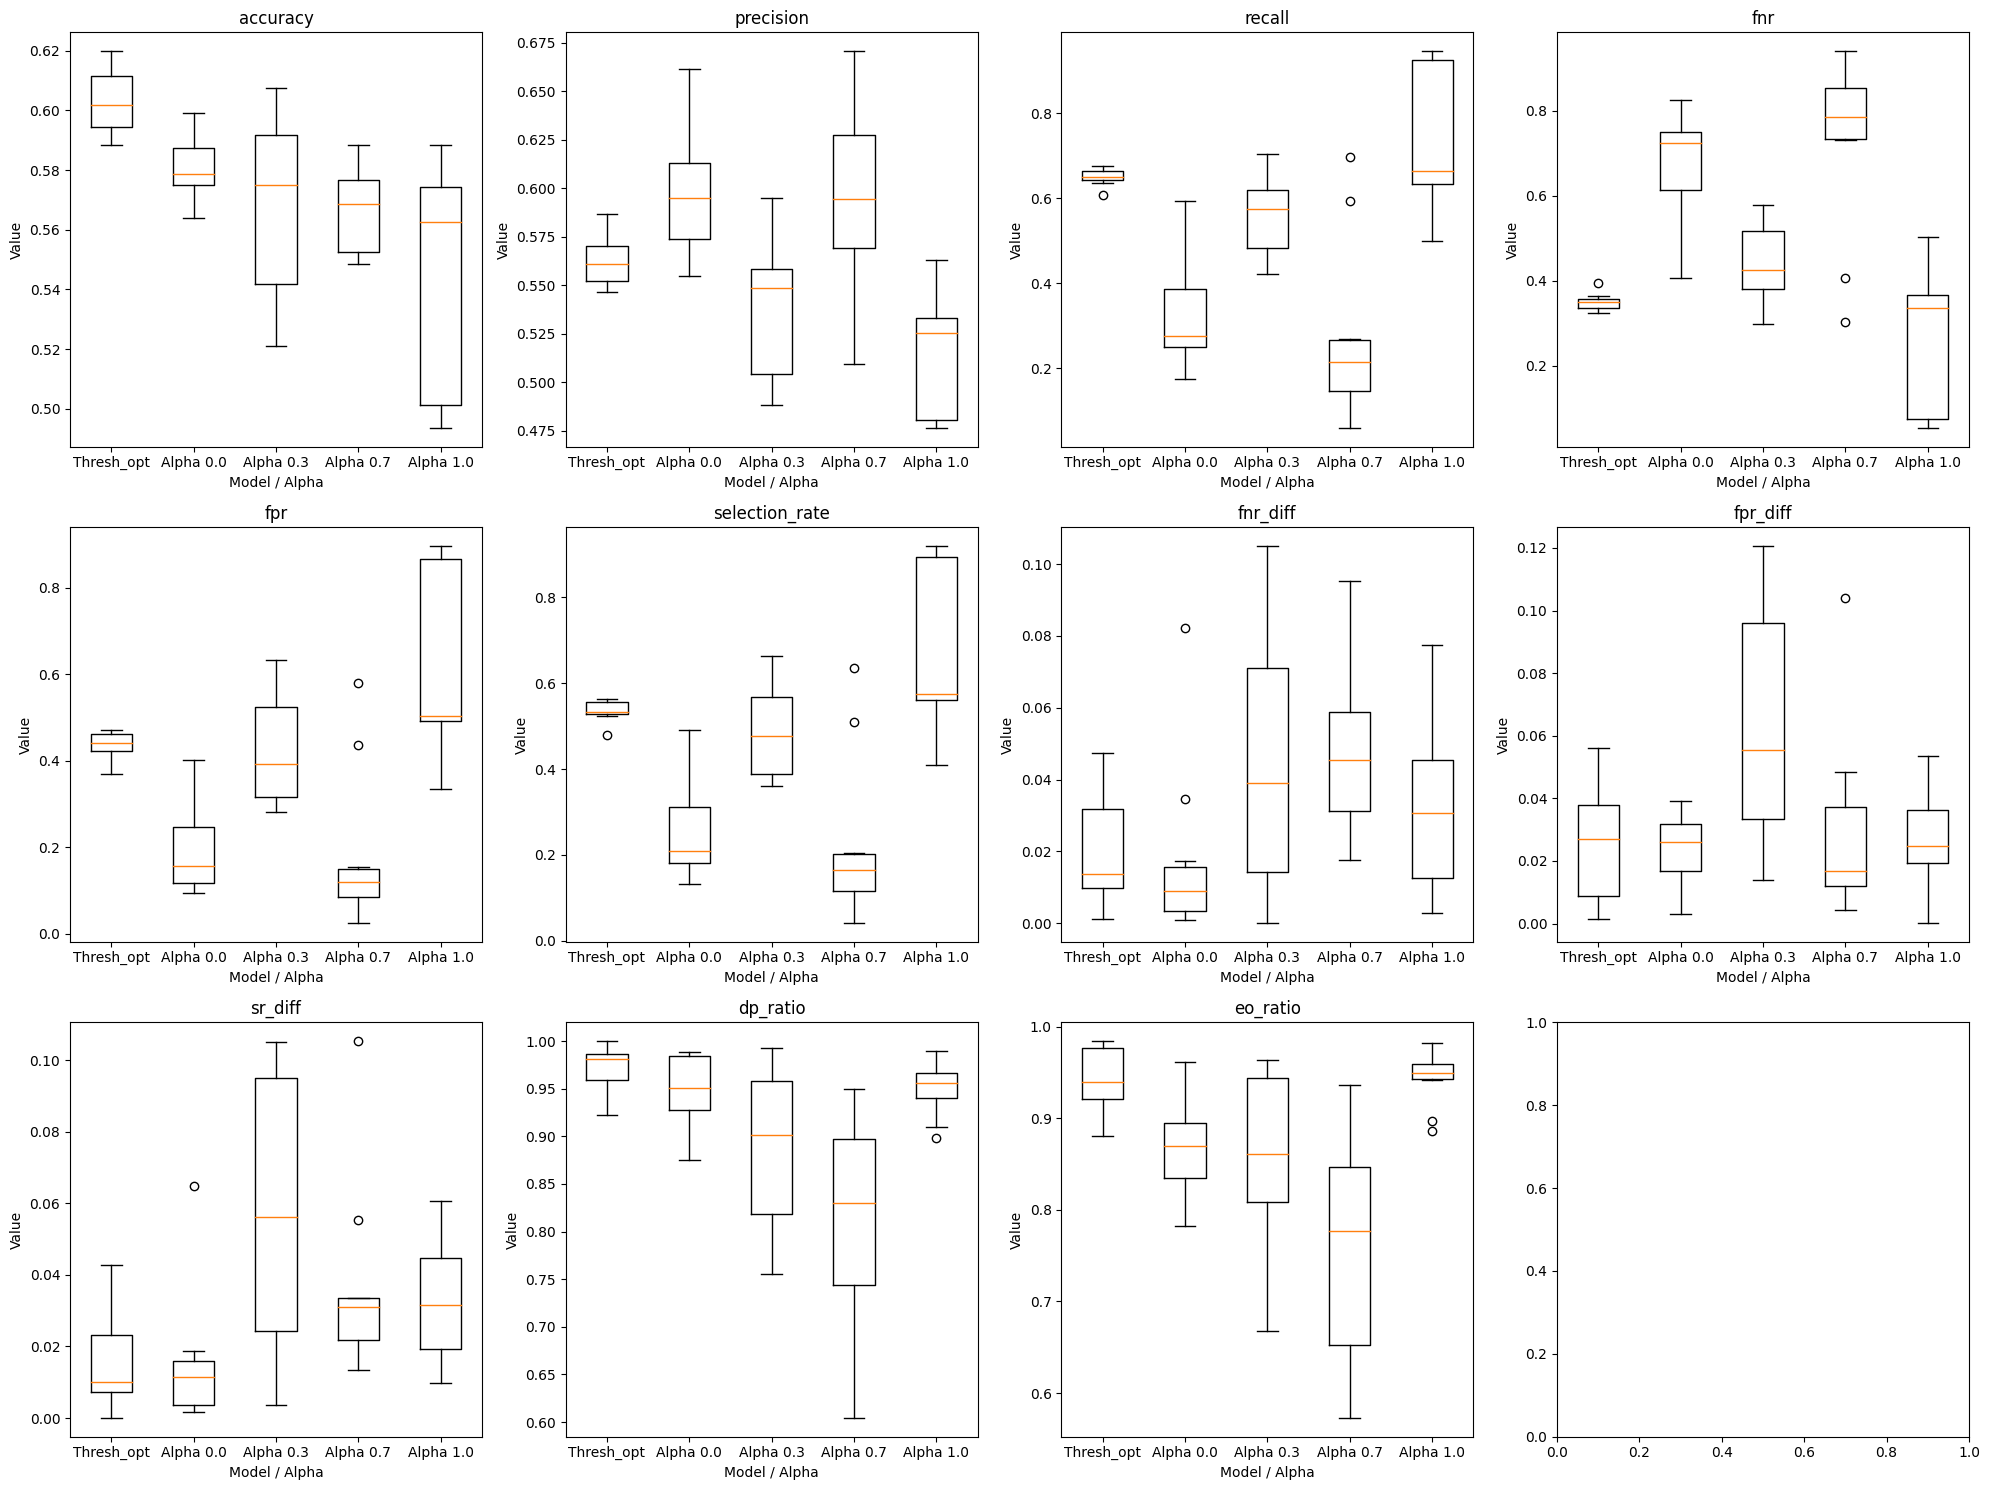

In [52]:
#@markdown graphing
alpha_values = [0.0, 0.3, 0.7, 1.0]
metrics_list = ['accuracy', 'precision', 'recall', 'fnr', 'fpr', 'selection_rate', 'fnr_diff', 'fpr_diff', 'sr_diff', 'dp_ratio', 'eo_ratio']

threshold_optimizer = {metric: [] for metric in metrics_list}
for result in results_df['threshold_optimizer']:
    for metric in metrics_list:
        threshold_optimizer[metric].append(result[metric])


atc_results = {metric: {alpha: [] for alpha in alpha_values} for metric in metrics_list}
for metric in metrics_list:
    num_runs_per_alpha = len(metrics_results[metric]) // len(alpha_values)
    metric_results = np.array(metrics_results[metric]).reshape(-1, num_runs_per_alpha)
    for i, alpha in enumerate(alpha_values):
        atc_results[metric][alpha] = metric_results[i]

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()

for i, metric in enumerate(metrics_list):
    data = [threshold_optimizer[metric]] + [atc_results[metric][alpha] for alpha in alpha_values]
    axs[i].boxplot(data, labels=['Thresh_opt', 'Alpha 0.0', 'Alpha 0.3', 'Alpha 0.7', 'Alpha 1.0'])

    axs[i].set_title(metric)
    axs[i].set_ylabel('Value')
    axs[i].set_xlabel('Model / Alpha')

plt.tight_layout()

plt.show()